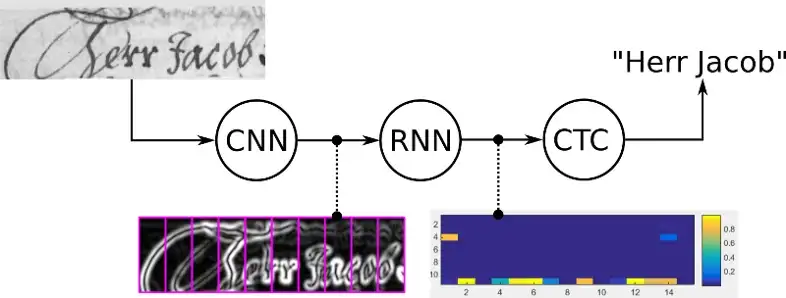

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip "/content/gdrive/MyDrive/ml/HandwritingRecognition/train_v2.zip"
!unzip "/content/gdrive/MyDrive/ml/HandwritingRecognition/test_v2.zip"
!unzip "/content/gdrive/MyDrive/ml/HandwritingRecognition/validation_v2.zip"

Streaming output truncated to the last 5000 lines.
  inflating: validation/VALIDATION_5000.jpg  
  inflating: validation/VALIDATION_5001.jpg  
  inflating: validation/VALIDATION_5002.jpg  
  inflating: validation/VALIDATION_5003.jpg  
  inflating: validation/VALIDATION_5004.jpg  
  inflating: validation/VALIDATION_5005.jpg  
  inflating: validation/VALIDATION_5006.jpg  
  inflating: validation/VALIDATION_5007.jpg  
  inflating: validation/VALIDATION_5008.jpg  
  inflating: validation/VALIDATION_5009.jpg  
  inflating: validation/VALIDATION_5010.jpg  
  inflating: validation/VALIDATION_5011.jpg  
  inflating: validation/VALIDATION_5012.jpg  
  inflating: validation/VALIDATION_5013.jpg  
  inflating: validation/VALIDATION_5014.jpg  
  inflating: validation/VALIDATION_5015.jpg  
  inflating: validation/VALIDATION_5016.jpg  
  inflating: validation/VALIDATION_5017.jpg  
  inflating: validation/VALIDATION_5018.jpg  
  inflating: validation/VALIDATION_5019.jpg  
  inflating: validation/VALID

In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

# Data

In [4]:
train = pd.read_csv('/content/gdrive/MyDrive/ml/HandwritingRecognition/written_name_train_v2.csv')
valid = pd.read_csv('/content/gdrive/MyDrive/ml/HandwritingRecognition/written_name_validation_v2.csv')

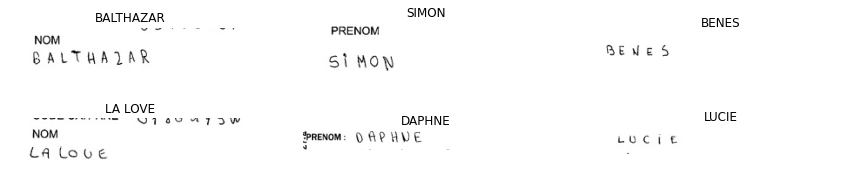

In [5]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# Cleaning Data - Let's check for NaNs in our label.

In [6]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


In [7]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

Also, there are some images in our data with the label 'UNREADABLE'. Lets check those images and remove them.

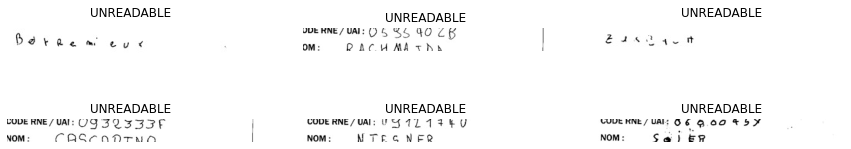

In [8]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [9]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

There are some labels which are in lowercase. To maintain uniformity in the labels, I convert all the labels to uppercase.

In [10]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

<ipython-input-10-0a9d753a51e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['IDENTITY'] = train['IDENTITY'].str.upper()
<ipython-input-10-0a9d753a51e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['IDENTITY'] = valid['IDENTITY'].str.upper()


In [11]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

Preprocessing and preparing the images for training

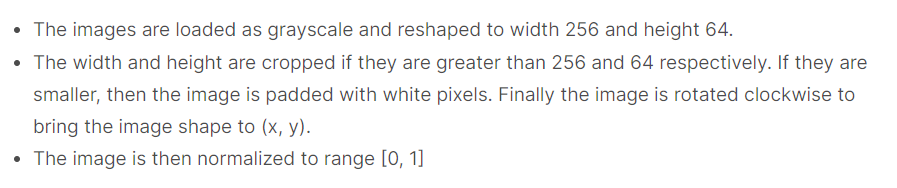

In [12]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

The model will be trained on 30000 images and validate on 3000 images

In [13]:
train_size = 30000
valid_size= 3000

In [14]:
train_x = []

for i in range(train_size):
    img_dir = '/content/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [15]:
valid_x = []

for i in range(valid_size):
    img_dir = '/content/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [16]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [17]:
(train_x.shape,valid_x.shape)

((30000, 256, 64, 1), (3000, 256, 64, 1))

# Preparing the labels for CTC Loss

## Why we want to use CTC
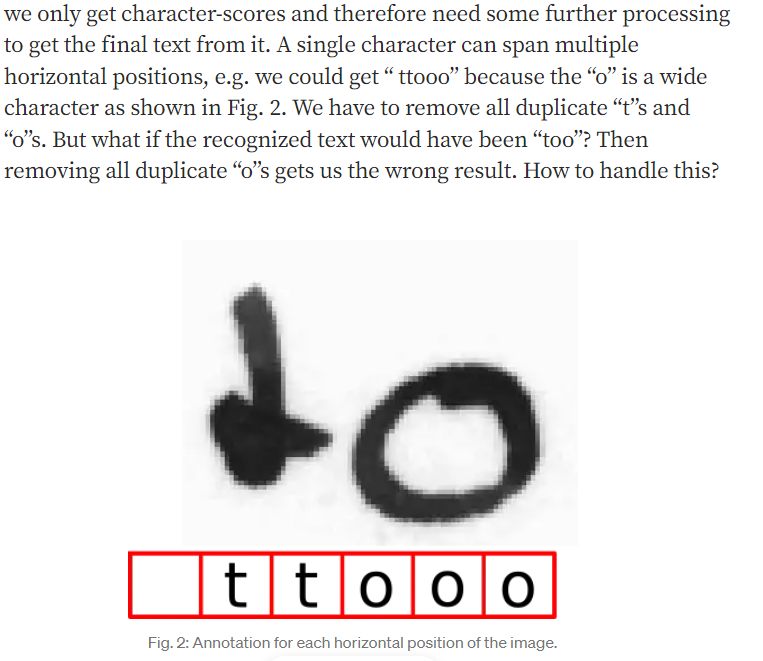

## How CTC works
An example is shown in Fig. 4. The characters are “a”, “b” and “-” (blank). There are 5 time-steps. Let’s apply our best path decoder to this matrix: the most likely character of t0 is “a”, the same applies for t1 and t2. The blank character has the highest score at t3. Finally, “b” is most likely at t4. This gives us the path “aaa-b”. We remove duplicate characters, this yields “a-b”, and then we remove any blank from the remaining path, which gives us the text “ab” which we output as the recognized text.

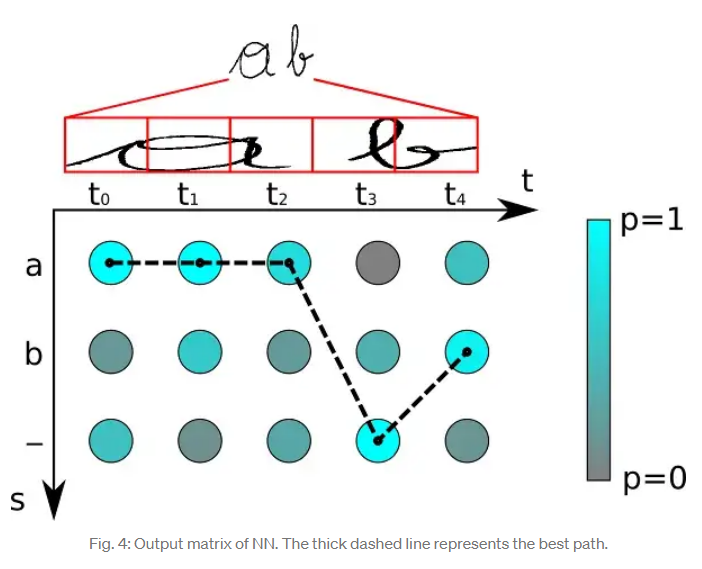

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (- ' and space).

In [18]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [19]:
name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


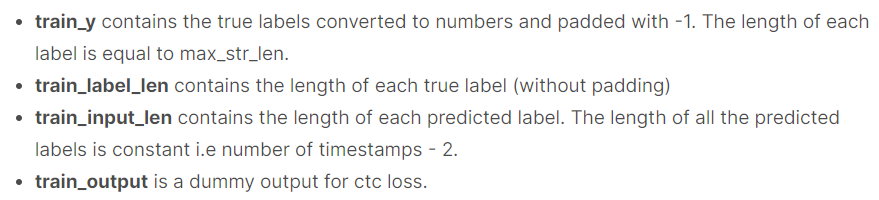

In [20]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])  

In [30]:
print('\ntrain_y: ',train_y.shape,'\ntrain_label_len: ',train_label_len.shape,'\ntrain_input_len: ',train_input_len.shape,'\ntrain_output: ',train_output.shape)


train_y:  (30000, 24) 
train_label_len:  (30000, 1) 
train_input_len:  (30000, 1) 
train_output:  (30000,)


In [32]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

In [34]:
print('\nvalid_y: ',valid_y.shape,'\nvalid_label_len: ',valid_label_len.shape,'\nvalid_input_len: ',valid_input_len.shape,'\nvalid_output: ',valid_output.shape)


valid_y:  (3000, 24) 
valid_label_len:  (3000, 1) 
valid_input_len:  (3000, 1) 
valid_output:  (3000,)


In [35]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


#Model

In [36]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

The output shape of the predictions is (64, 30). The model predicts words of 64 characters and each character contains the probability of the 30 alphabets which we defined earlier.

In [37]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    # Runs CTC loss algorithm on each batch element.
    # Returns: Tensor with shape (samples,1) containing the CTC loss of each element.
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [38]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

#Train

In [39]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
235/235 [==============================] - 39s 90ms/step - loss: 23.9569 - val_loss: 20.8253
Epoch 2/60
235/235 [==============================] - 19s 80ms/step - loss: 20.1306 - val_loss: 20.0093
Epoch 3/60
235/235 [==============================] - 19s 81ms/step - loss: 19.7748 - val_loss: 19.6104
Epoch 4/60
235/235 [==============================] - 19s 80ms/step - loss: 19.2509 - val_loss: 18.7951
Epoch 5/60
235/235 [==============================] - 19s 80ms/step - loss: 18.1545 - val_loss: 17.3430
Epoch 6/60
235/235 [==============================] - 19s 81ms/step - loss: 16.6931 - val_loss: 15.6265
Epoch 7/60
235/235 [==============================] - 19s 81ms/step - loss: 14.7869 - val_loss: 13.8791
Epoch 8/60
235/235 [==============================] - 19s 79ms/step - loss: 12.6687 - val_loss: 11.5346
Epoch 9/60
235/235 [==============================] - 19s 79ms/step - loss: 10.4926 - val_loss: 8.8449
Epoch 10/60
235/235 [==============================] - 19s 81ms/s

#Evaluate model performance on validation set

In [40]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

94/94 [==============================] - 2s 11ms/step


In [41]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 88.13%
Correct words predicted      : 74.47%


# predictions on test set

1/1 [==============================] - 0s 20ms/step


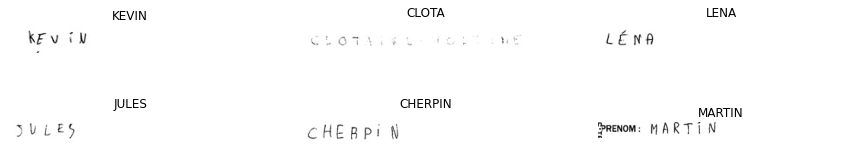

In [42]:
test = pd.read_csv('/content/gdrive/MyDrive/ml/HandwritingRecognition/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

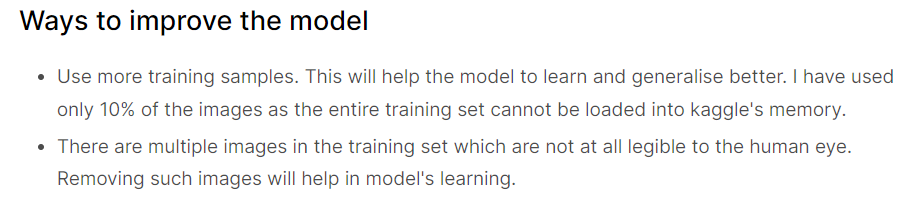